In [872]:
import pandas as pd
import numpy as np
from scipy.stats import moment
import scipy
import statsmodels.api as sm
import quantstats as qs
import seaborn as sns
import matplotlib.pyplot as plt

In [259]:
hedgefund_series = pd.read_excel("./data/proshares_analysis_data.xlsx",sheet_name = "hedge_fund_series",index_col=0)
merrill_factors = pd.read_excel("./data/proshares_analysis_data.xlsx",sheet_name = "merrill_factors",index_col=0)

In [1489]:
class PortfolioHelper():
    def __init__(self,df:pd.DataFrame,df_regressor: pd.DataFrame):
        self.df = df 
        self.df_regressor = df_regressor
        
    def summary_statistics(self,period:int): # monthly_data annualized
        mean = self.df.mean()*period
        std = self.df.std()*np.sqrt(period)
        sharpe = mean / std

        summary_df = pd.DataFrame({"mean":mean,"std":std,"sharpe":sharpe})
        
        return summary_df.sort_values(by='sharpe',ascending=False)

    def tail_risk(self,alpha:int): # alpha is significance level
        skew = scipy.stats.skew(self.df, axis=0, bias= False)
        kurtosis = scipy.stats.kurtosis(self.df, axis=0, bias= False)-3
        var = np.quantile(self.df,alpha,axis=0)
        cvar = self.df.apply(lambda col: col[col <= var[self.df.columns.get_loc(col.name)]].mean()).values
        
        
        summary_df = pd.DataFrame([skew,kurtosis,var,cvar],index=['skew','kurtosis','var','cvar'],columns=self.df.columns).transpose()
        return summary_df
    
    def maximum_drawdown(self,df:pd.DataFrame):
        # dates of max/min/recovery within max drawdown period
        dd = qs.stats.to_drawdown_series(df)
        drawdown_details = qs.stats.drawdown_details(dd)

        return drawdown_details
        
    def OLS(self,y:str,x,add_constant:bool): # x : str or list of str
        if add_constant == True:
            x = sm.add_constant(self.df_regressor[x])
            results = sm.OLS(self.df[y],x).fit()
        else: 
            results = sm.OLS(self.df[y],self.df_regressor[x]).fit()
        
        return results
    
    def regression_based_metric(self,y,x,period,add_constant): # simple linear regression
        r = self.OLS(y,x,add_constant)
        beta = r.params[r.params.index!='const'].values[0] # series
        treynor_ratio = (self.df[y].mean() / beta) * period
        information_ratio = (r.params[r.params.index == 'const'].iloc[0]/ r.resid.std())*np.sqrt(period)

        return pd.Series([beta,treynor_ratio,information_ratio],index=['beta','treynor_ratio','information_ratio'])

    
    def correlation_matrix(self):
        # visualise and max, min, pair
        corr = self.df.corr().values
        np.fill_diagonal(corr,np.nan) # fill diagonal with nan
        max_pair = np.unravel_index(np.nanargmax(corr),shape=corr.shape)
        min_pair = np.unravel_index(np.nanargmin(corr),shape=corr.shape)

        display(sns.heatmap(self.df.corr(),annot=True))
        return max_pair,min_pair

    # def oos_backtest(self,train_period,test_period):
        
        
        

1. For the series in the "hedge fund series" tab, report the following summary statistics.

In [1496]:
a= PortfolioHelper(hedgefund_series,merrill_factors)
a.summary_statistics(12)

,mean,std,sharpe
HFRIFWI Index,0.048295,0.059476,0.812004
MLEIFCTR Index,0.036286,0.056136,0.646398
MLEIFCTX Index,0.034605,0.055980,0.618172
QAI US Equity,0.025653,0.050009,0.512971
HDG US Equity,0.024812,0.058408,0.424805


For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk

In [1499]:
a.tail_risk(0.05)

,skew,kurtosis,var,cvar
HFRIFWI Index,-0.963318,2.763074,-0.024293,-0.037478
MLEIFCTR Index,-0.265394,-1.368420,-0.028189,-0.035857
MLEIFCTX Index,-0.251279,-1.404137,-0.028095,-0.035816
HDG US Equity,-0.254201,-1.240750,-0.030932,-0.037575
QAI US Equity,-0.434775,-1.394066,-0.017895,-0.032695


In [1501]:
a.maximum_drawdown(hedgefund_series)

HFRIFWI Index                                                               \
           start      valley         end   days max drawdown 99% max drawdown   
0     2011-09-30  2011-09-30  2012-01-31  124.0    -3.890327        -3.072775   
1     2012-03-31  2012-05-31  2012-11-30  245.0    -3.281424        -3.003031   
2     2013-06-30  2013-06-30  2013-08-31   63.0    -1.468377        -0.886902   
3     2014-01-31  2014-01-31  2014-01-31    1.0    -0.537572              NaN   
4     2014-03-31  2014-04-30  2014-04-30   31.0    -0.509499        -0.294940   
5     2014-07-31  2014-07-31  2014-07-31    1.0    -0.626348              NaN   
6     2014-09-30  2014-10-31  2015-01-31  124.0    -1.316632        -0.920532   
7     2015-06-30  2016-02-29  2016-11-30  520.0    -7.234477        -7.203493   
8     2018-02-28  2018-12-31  2019-06-30  488.0    -6.900383        -4.475274   
9     2019-08-31  2019-09-30  2019-10-31   62.0    -0.983068        -0.780960   
10    2020-01-31  2020-03-31  2020-07-31  183.0   -11.547316        -7.547840   
11    2020-09-30  2020-09-30  2020-10-31   32.0    -0.929167        -0.763860   
12    2021-07-31  2021-07-31  2021-09-30   62.0    -0.909529        -0.392346   
13    2021-11-30  2022-09-30  2023-11-30  731.0    -7.133167        -6.460343   
14    2024-04-30  2024-04-30  2024-04-30    1.0    -0.690000              NaN   
15    2024-06-30  2024-06-30  2024-06-30    1.0    -0.030000              NaN   
16           NaN         NaN         NaN    NaN          NaN              NaN   
17           NaN         NaN         NaN    NaN          NaN              NaN   
18           NaN         NaN         NaN    NaN          NaN              NaN   
19           NaN         NaN         NaN    NaN          NaN              NaN   
20           NaN         NaN         NaN    NaN          NaN              NaN   

   MLEIFCTR Index                               ... HDG US Equity          \
            start      valley         end days  ...           end    days   
0      2011-09-30  2011-09-30  2011-09-30    1  ...    2011-09-30     1.0   
1      2011-11-30  2011-11-30  2011-12-31   32  ...    2011-12-31    32.0   
2      2012-03-31  2012-05-31  2012-11-30  245  ...    2012-12-31   276.0   
3      2013-02-28  2013-02-28  2013-02-28    1  ...    2013-03-31    32.0   
4      2013-05-31  2013-06-30  2013-08-31   93  ...    2013-08-31    93.0   
5      2014-01-31  2014-01-31  2014-02-28   29  ...    2014-04-30   152.0   
6      2014-04-30  2014-04-30  2014-04-30    1  ...    2014-07-31     1.0   
7      2014-07-31  2014-07-31  2014-07-31    1  ...    2014-10-31    32.0   
8      2014-09-30  2014-09-30  2014-10-31   32  ...    2015-01-31    32.0   
9      2014-12-31  2014-12-31  2015-01-31   32  ...    2017-01-31   582.0   
10     2015-03-31  2015-03-31  2015-03-31    1  ...    2017-05-31     1.0   
11     2015-06-30  2016-02-29  2016-08-31  429  ...    2019-03-31   397.0   
12     2016-10-31  2016-10-31  2016-10-31    1  ...    2019-05-31     1.0   
13     2018-02-28  2018-03-31  2018-07-31  154  ...    2019-09-30    62.0   
14     2018-09-30  2018-12-31  2019-02-28  152  ...    2020-10-31   246.0   
15     2019-05-31  2019-05-31  2019-05-31    1  ...    2021-03-31     1.0   
16     2019-08-31  2019-08-31  2019-09-30   31  ...    2021-05-31     1.0   
17     2020-01-31  2020-03-31  2020-10-31  275  ...    2024-06-30  1066.0   
18     2021-07-31  2022-09-30  2024-01-31  915  ...    2024-08-31     1.0   
19     2024-04-30  2024-04-30  2024-04-30    1  ...           NaN     NaN   
20     2024-08-31  2024-08-31  2024-08-31    1  ...           NaN     NaN   

                                 QAI US Equity                                 \
   max drawdown 99% max drawdown         start      valley         end   days   
0     -3.246634              NaN    2011-09-30  2011-09-30  2011-09-30    1.0   
1     -2.860763        -1.610141    2011-11-30  2011-11-30  2011-12-31   32.0   
2     -5.051124        -3.210103    2012-03

3. For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics

In [1504]:
merge = []
for i in (hedgefund_series.columns):
    
    series = a.regression_based_metric(i,'SPY US Equity',12,True)
    merge.append(series)
merge_df = pd.concat(merge,axis=1,keys=hedgefund_series.columns)
merge_df

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
beta,0.346131,0.343383,0.342171,0.352053,0.298376
treynor_ratio,0.139528,0.105672,0.101134,0.070478,0.085976
information_ratio,-0.035836,-0.491479,-0.549547,-0.896268,-0.675558


4. Discuss the previous statistics, and what they tell us about...

a) the differences between SPY and the hedge-fund series?
- Information Ratio is negative for all hedgefunds meaning that every unit of tracking error it yields negative profit.
 
b) which performs better between HDG and QAI.
- In terms of both treynor_ratio and information_ratio QAI performs better. QAI gives better expected return over same market exposure(treynor ratio) and less negative alpha for std of unit residuals.
 
c) whether HDG and the ML series capture the most notable properties of HFRI.
- Most notable property of HRFI is that it has excess kurtosis over normal distribution but the other two exhibits negative excess kurtosis

5. 
Report the correlation matrix for these assets

- Show the correlations as a heat map.- 
Which series have the highest and lowest correlations?.

<Axes: >

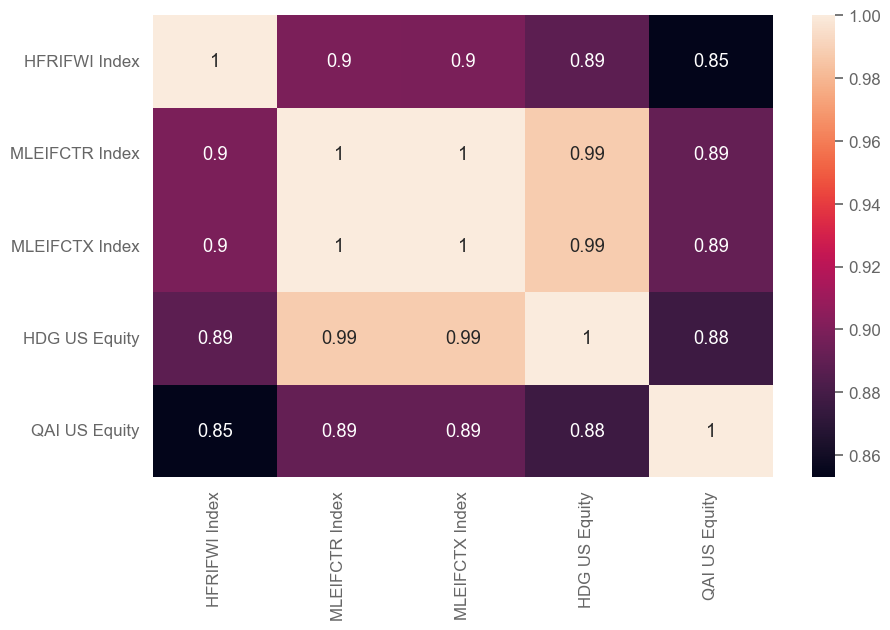

In [1216]:
max,min = a.correlation_matrix()

In [1217]:
corr_matrix = hedgefund_series.corr()

# Access the maximum correlation value using the index
max_value = corr_matrix.iloc[max]
min_value = corr_matrix.iloc[min]

# Print the results
print(f"Maximum Correlation {corr_matrix.index[max[0]]}-{corr_matrix.columns[max[1]]}: {max_value} Minimum Correlation {corr_matrix.index[min[0]]}-{corr_matrix.columns[min[1]]}: {min_value}")

Maximum Correlation MLEIFCTR Index-MLEIFCTX Index: 0.9999094742612991 Minimum Correlation HFRIFWI Index-QAI US Equity: 0.8529985218248729


6.
Replicate HFRI with the six factors listed on the "merrill factors" tab Include a constant and run the unrestricted regresson

- a. Report the intercept and betas.
- b. Are the betas realistic position sizes, or do they require huge long-short positions?
- c. Report the R-squared.
- d. Report the volatility of 
, the tracking error.n

In [1218]:
reg = a.OLS("HFRIFWI Index",merrill_factors.columns,True)

In [1219]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sat, 12 Oct 2024   Prob (F-statistic):           1.99e-57
Time:                        21:29:06   Log-Likelihood:                 563.14
No. Observations:                 158   AIC:                            -1112.
Df Residuals:                     151   BIC:                            -1091.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      1.702      0.091      -0.000       0.003
SPY US Equity     0.0365      0.034      1.072      0.286      -0.031       0.104
USGG3M Index      0.1463      0.376      0.389      0.698      -0.596       0.889
EEM US Equity     0.0816      0.020      4.049      0.000       0.042       0.121
EFA US Equity     0.0846      0.034      2.473      0.015       0.017       0.152
EUO US Equity     0.0288      0.017      1.701      0.091      -0.005       0.062
IWM US Equity     0.1451      0.020      7.103      0.000       0.105       0.185
==============================================================================
Omnibus:                       24.101   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.919
Skew:                          -0.458   Prob(JB):                     3.63e-19
Kurtosis:                       6.473   Cond. No.                         674.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1220]:
resid_error= reg.resid.std()
resid_error

0.00687466807687868

a. See coef above b. They do not require huge long-short positions c. see R-squared above d. 0.68%(annualized)

7. Let's examine the replication out-of-sample (OOS).
- How well does the out-of-sample replication perform with respect to the target?
  > It is pretty similar..

In [1577]:
train_period = 60
test_period = 1

oos_ts = []
betas_w = []
for i in np.arange(train_period,hedgefund_series.shape[0]-test_period):
    oos= PortfolioHelper(hedgefund_series.iloc[i-train_period:i],merrill_factors.iloc[i-train_period:i])
    reg = oos.OLS("HFRIFWI Index",merrill_factors.columns,True)
    betas_w.append(reg.params.iloc[1:]) # including alpha
     
    estimate = (reg.params.iloc[1:].T @ merrill_factors.iloc[i])
    real = hedgefund_series["HFRIFWI Index"].iloc[i]
    error = estimate-real
    oos_ts.append([estimate,real,error])

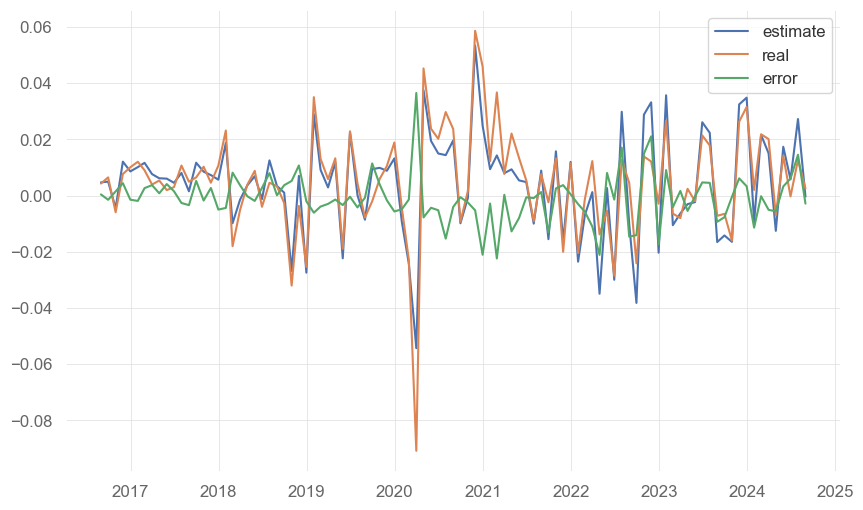

In [1605]:
rep_df = pd.DataFrame(oos_ts,columns=['estimate','real','error'],index = hedgefund_series.index[train_period:hedgefund_series.shape[0]-test_period] )
plt.plot(rep_df)
plt.legend(rep_df.columns)

8. We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

In [1611]:
train_period = 60
test_period = 1

oos_ts = []
betas_wo = []
for i in np.arange(train_period,hedgefund_series.shape[0]-test_period):
    oos= PortfolioHelper(hedgefund_series.iloc[i-train_period:i],merrill_factors.iloc[i-train_period:i])
    reg = oos.OLS("HFRIFWI Index",merrill_factors.columns,False)
    betas_wo.append(reg.params) # including alpha
     
    estimate = (reg.params.T @ merrill_factors.iloc[i])
    real = hedgefund_series["HFRIFWI Index"].iloc[i]
    error = estimate-real
    oos_ts.append([estimate,real,error])

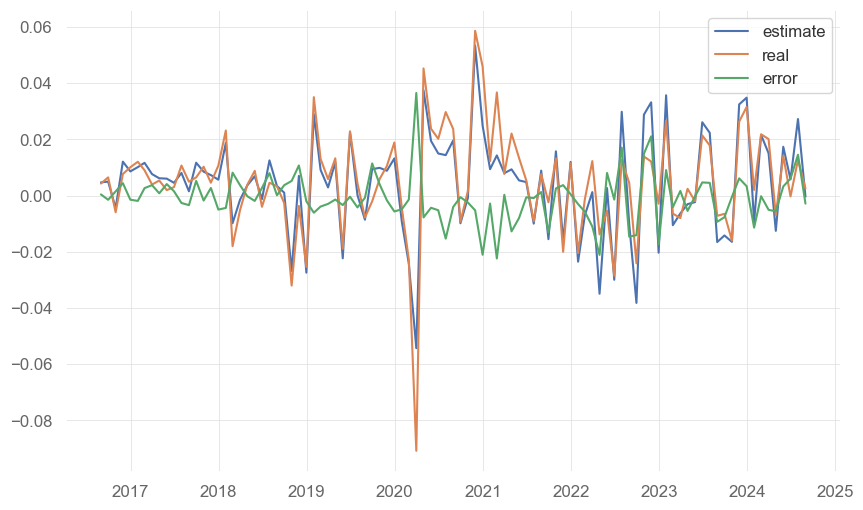

In [1613]:
rep_df = pd.DataFrame(oos_ts,columns=['estimate','real','error'],index = hedgefund_series.index[train_period:hedgefund_series.shape[0]-test_period] )
plt.plot(rep_df)
plt.legend(rep_df.columns)

In [1615]:
beta_w_df = pd.DataFrame(betas_w,index = merrill_factors.index[60:157])
beta_wo_df = pd.DataFrame(betas_wo,index = merrill_factors.index[60:157])
beta_w_df - beta_wo_df

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2016-08-31,0.007468,2.728391,-0.002117,-0.000891,0.000859,-0.001077
2016-09-30,0.003328,1.183403,-0.000958,-0.000140,0.000538,-0.000417
2016-10-31,0.001036,0.370350,-0.000271,-0.000059,0.000154,-0.000108
2016-11-30,-0.003140,-1.166869,0.001047,-0.000016,-0.000473,0.000368
2016-12-31,-0.012248,-3.580526,0.003013,-0.000813,-0.001250,0.003985
...,...,...,...,...,...,...
2024-04-30,-0.029780,-1.021263,-0.003446,0.016593,-0.008750,0.006460
2024-05-31,-0.029130,-1.000407,-0.002639,0.016332,-0.008051,0.005821
2024-06-30,-0.030496,-0.957194,-0.004897,0.017796,-0.009161,0.006311
2024-07-31,-0.026296,-0.961506,-0.001719,0.013195,-0.008753,0.004770


In [1587]:
beta_wo_df

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2016-08-31,0.081417,7.448558,0.051519,0.121672,0.022386,0.074726
2016-09-30,0.090847,7.261031,0.051003,0.112069,0.018300,0.070072
2016-10-31,0.095692,8.215412,0.044482,0.114514,0.021475,0.065242
2016-11-30,0.111531,5.980118,0.058950,0.092429,0.019937,0.075884
2016-12-31,0.119586,3.907457,0.063079,0.089724,0.023236,0.067600
...,...,...,...,...,...,...
2024-04-30,0.020915,0.761272,0.099296,0.005849,0.030525,0.226161
2024-05-31,0.020200,0.826076,0.103823,0.005038,0.032890,0.223495
2024-06-30,0.024582,0.751372,0.109796,0.000602,0.036313,0.221889
2024-07-31,0.014905,0.707672,0.102983,0.011491,0.033980,0.225585


In [1589]:
beta_w_df

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2016-08-31,0.088884,10.176949,0.049402,0.120781,0.023245,0.073649
2016-09-30,0.094174,8.444434,0.050045,0.111930,0.018838,0.069655
2016-10-31,0.096728,8.585762,0.044211,0.114455,0.021629,0.065134
2016-11-30,0.108391,4.813249,0.059997,0.092413,0.019464,0.076252
2016-12-31,0.107338,0.326931,0.066092,0.088911,0.021986,0.071585
...,...,...,...,...,...,...
2024-04-30,-0.008865,-0.259991,0.095850,0.022442,0.021775,0.232621
2024-05-31,-0.008930,-0.174331,0.101184,0.021369,0.024839,0.229316
2024-06-30,-0.005914,-0.205822,0.104899,0.018399,0.027153,0.228200
2024-07-31,-0.011391,-0.253834,0.101264,0.024686,0.025227,0.230355


In [1591]:
(beta_w_df-beta_wo_df).describe()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,-0.017173,-1.154594,-0.001499,0.009134,-0.002049,0.003073
std,0.015012,0.984182,0.003674,0.009952,0.005429,0.004616
min,-0.048130,-3.580526,-0.010781,-0.007933,-0.013423,-0.010469
25%,-0.030496,-1.831537,-0.003729,0.001348,-0.003296,0.000127
50%,-0.014353,-1.166869,-0.000883,0.006113,-0.001306,0.002697
75%,-0.005164,-0.449129,0.000657,0.016332,0.000154,0.005821
max,0.011225,2.728391,0.004717,0.036797,0.008786,0.014795


In [1593]:
# compare fitted with real mean
est_wo= beta_wo_df.shift(1) * merrill_factors.iloc[60:-1] # estimated without constant
est_w= beta_w_df.shift(1) * merrill_factors.iloc[60:-1] # estimated with constant

est_wo['Total sum'] = np.sum(est_wo,axis=1)
est_wo['Real'] = hedgefund_series.iloc[60:-1]['HFRIFWI Index']

est_w['Total sum'] = np.sum(est_w,axis=1)
est_w['Real'] = hedgefund_series.iloc[60:-1]['HFRIFWI Index']

est_wo.dropna(inplace=True)
est_w.dropna(inplace=True)

In [1595]:
np.mean(est_wo[['Total sum','Real']],axis=0)

Total sum    0.004075
Real         0.004993
dtype: float64

In [1597]:
est_wo[['Total sum','Real']].corr()

,Total sum,Real
Total sum,1.000000,0.892689
Real,0.892689,1.000000


In [1599]:
est_w[['Total sum','Real']].corr()

,Total sum,Real
Total sum,1.000000,0.889155
Real,0.889155,1.000000
